In [1]:
from gEcon.classes.model import gEconModel
from gEcon.shared.dynare_convert import make_mod_file
from gEcon.plotting import plotting as gp

import numpy as np
import sympy as sp

# Load Model - Basic Model

This GCN file is fully compatable with the original R version of gEcon, and doesn't include any of the new features of gEcon.py.

If you look at the file, it also includes an `options` and `tryreduce` block. Note that these **DO NOT** do anything in gEcon.py. They are parsed and saved for compatability with GCN files written for the R version only (for now).

In [2]:
file_path = 'GCN Files/RBC_basic.gcn'
model = gEconModel(file_path, verbose=True)

Model Building Complete.
Found:
	13 equations
	13 variables
	1 stochastic shock
		 0 / 1 has a defined prior. 
	6 parameters
		 0 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations

All the FoC are saved in the model object and can be manipulated using Sympy if needed

In [3]:
for eq in model.system_equations:
    display(eq)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

beta*U_t+1 + C_t**(1 - sigma_C)/(1 - sigma_C) - L_t**(sigma_L + 1)/(sigma_L + 1) - U_t

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

-lambda_t + q_t

beta*(lambda_t+1*r_t+1 + q_t+1*(1 - delta)) - q_t

1 - mc_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

-K_t-1*r_t - L_t*w_t - TC_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha)*mc_t - r_t

A_t*K_t-1**alpha*mc_t*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Calibrating Relationships

In [4]:
for eq in model.calibrating_equations:
    display(eq)

# Solve Steady State

By default, the steady state is found using a combination of Sympy simplifications and scipy optimizers. It can be slow the first time it is run, but it builds a function which can be reused to re-solve the steady-state much more quickly. This is useful when sampling from the prior or posterior.

In [5]:
%time model.steady_state()

Steady state found! Sum of squared residuals is 1.5162530527818997e-20
Wall time: 605 ms


The function to solve a new steady state is called `f_ss`, and it takes a dictionary of free parameters as an input, and returns two dictionaries: one with values of variables in the steady state, and one with values of calibrated parameters.

In [6]:
%time model.f_ss(model.free_param_dict)

Wall time: 1.99 ms


({'A_ss': 1.0,
  'C_ss': 2.3584361407711434,
  'I_ss': 0.7146463689728967,
  'K_ss': 35.73231844864443,
  'L_ss': 0.8200691321782412,
  'TC_ss': -3.07308250974404,
  'U_ss': -148.61564958778027,
  'Y_ss': 3.073082509723429,
  'lambda_ss': 0.27609835424696155,
  'mc_ss': 1.0,
  'q_ss': 0.27609835424696155,
  'r_ss': 0.030101010098116873,
  'w_ss': 2.4357746840928156},
 {})

## Steady State Equations

You also have access to the steady state equations, if you need them.

In [7]:
for eq in model.steady_state_system:
    display(eq)

-C_ss - I_ss + K_ss*r_ss + L_ss*w_ss

I_ss + K_ss*(1 - delta) - K_ss

beta*U_ss + C_ss**(1 - sigma_C)/(1 - sigma_C) - L_ss**(sigma_L + 1)/(sigma_L + 1) - U_ss

-lambda_ss + C_ss**(-sigma_C)

-L_ss**sigma_L + lambda_ss*w_ss

-lambda_ss + q_ss

beta*(lambda_ss*r_ss + q_ss*(1 - delta)) - q_ss

1 - mc_ss

A_ss*K_ss**alpha*L_ss**(1 - alpha) - Y_ss

-K_ss*r_ss - L_ss*w_ss - TC_ss

alpha*A_ss*K_ss**(alpha - 1)*L_ss**(1 - alpha)*mc_ss - r_ss

A_ss*K_ss**alpha*mc_ss*(1 - alpha)/L_ss**alpha - w_ss

rho_A*log(A_ss) - log(A_ss)

# Perturbation Solution

Like the steady state solution, the perturbation solution constructs a function to solve linearized system via perturbation. The first time you run the function will be slower. 

In [8]:
%time model.solve_model()

Gensys found a unique solution.
Policy matrices have been stored in attributes model.P, model.Q, model.R, and model.S
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Wall time: 417 ms


The second run is much faster

In [9]:
%time model.solve_model()

Gensys found a unique solution.
Policy matrices have been stored in attributes model.P, model.Q, model.R, and model.S
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Wall time: 5.98 ms


In [10]:
for name, policy_matrix in zip(['P', 'Q', 'R', 'S'], [model.P, model.Q, model.R, model.S]):
    print(name.center(10).center(50, '='))
    print(policy_matrix.to_string())

====================    P     ====================
        A_t-1     K_t-1
A_t  0.950000  0.000000
K_t  0.072814  0.969745
====================    Q     ====================
     epsilon_A_t
A_t     1.000000
K_t     0.076646
====================    R     ====================
             A_t-1     K_t-1
C_t       0.309657  0.478747
I_t       3.640697 -0.512728
L_t       0.206602 -0.156647
TC_t      1.084291  0.248179
U_t      -0.091155 -0.067054
Y_t       1.084291  0.248179
lambda_t -0.464485 -0.718121
mc_t      0.000000  0.000000
q_t      -0.464485 -0.718121
r_t       1.084291 -0.751821
w_t       0.877689  0.404826
====================    S     ====================
          epsilon_A_t
C_t          0.325955
I_t          3.832313
L_t          0.217476
TC_t         1.141359
U_t         -0.095953
Y_t          1.141359
lambda_t    -0.488932
mc_t         0.000000
q_t         -0.488932
r_t          1.141359
w_t          0.923883


## Blanchard-Kahn Conditions

After you have a perturbation solution, you can check the Eigenvalues of the system to make sure the BK conditions are satisfied.

The output shows the eigenvalues computed by gensys: the modulus, real part, and imaginary part.

In [11]:
model.check_bk_condition()

Model solution has 4 eigenvalues greater than one in modulus and 3 forward-looking variables.
Blanchard-Kahn condition is satisfied.


,Modulus,Real,Imaginary
0,9.500000e-01,9.500000e-01,0.0
1,9.697454e-01,9.697454e-01,-0.0
2,1.010101e+00,1.010101e+00,0.0
3,1.041615e+00,1.041615e+00,-0.0
4,3.134587e+14,-3.134587e+14,0.0
5,1.662691e+15,1.662691e+15,0.0


You can also visualize the Eigenvalues using `plot_eigenvalues` in the plotting functions.

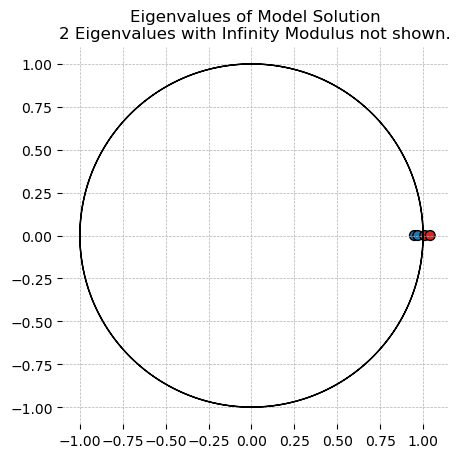

In [12]:
gp.plot_eigenvalues(model);

## Model Statistics

Functions to compute the stationary covariance matrix, as well as autocovariances for each variable, are also available.

In [13]:
sigma = model.compute_stationary_covariance_matrix()
acorr_matrix = model.compute_autocorrelation_matrix(n_lags=30)

In [14]:
sigma

,A,K,C,I,L,TC,U,Y,lambda,mc,q,r,w
A,0.102564,0.099834,0.078837,0.344429,0.007448,0.140600,-0.016201,0.140600,-0.118255,0.0,-0.118255,0.045758,0.133152
K,0.099834,0.246631,0.150521,0.256242,-0.016892,0.175107,-0.026104,0.175107,-0.225782,0.0,-0.225782,-0.071328,0.191998
C,0.078837,0.150521,0.097024,0.225738,-0.006193,0.126956,-0.017555,0.126956,-0.145536,0.0,-0.145536,-0.022030,0.133150
I,0.344429,0.256242,0.225738,1.198438,0.037778,0.451939,-0.048942,0.451939,-0.338607,0.0,-0.338607,0.214926,0.414162
L,0.007448,-0.016892,-0.006193,0.037778,0.004441,0.004032,0.000493,0.004032,0.009290,0.0,0.009290,0.022040,-0.000408
TC,0.140600,0.175107,0.126956,0.451939,0.004032,0.202531,-0.024854,0.202531,-0.190435,0.0,-0.190435,0.033074,0.198499
U,-0.016201,-0.026104,-0.017555,-0.048942,0.000493,-0.024854,0.003274,-0.024854,0.026332,0.0,0.026332,0.000784,-0.025347
Y,0.140600,0.175107,0.126956,0.451939,0.004032,0.202531,-0.024854,0.202531,-0.190435,0.0,-0.190435,0.033074,0.198499
lambda,-0.118255,-0.225782,-0.145536,-0.338607,0.009290,-0.190435,0.026332,-0.190435,0.218304,0.0,0.218304,0.033045,-0.199724
mc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


You can also plot the covaraince matrix as a heatmap using `gp.plot_covariance_heatmap`

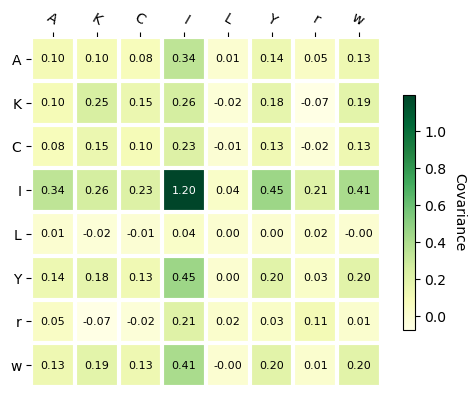

In [15]:
gp.plot_covariance_matrix(sigma, ['A', 'K', 'C', 'I', 'L', 'Y', 'r', 'w'],
                          figsize=(5,5),
                          cbar_kw=dict(shrink=0.5));

Similarly, there is a function to plot the autocorrelation functions, `plot_acf`

In [16]:
acorr_matrix

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
A,1.0,0.950000,0.902500,0.857375,0.814506,0.773781,0.735092,0.698337,0.663420,0.630249,...,0.358486,0.340562,0.323534,0.307357,0.291989,0.277390,0.263520,0.250344,0.237827,0.225936
K,1.0,0.999220,0.996990,0.993427,0.988642,0.982738,0.975813,0.967956,0.959254,0.949787,...,0.813312,0.799272,0.785128,0.770910,0.756646,0.742360,0.728076,0.713816,0.699598,0.685442
C,1.0,0.994332,0.987605,0.979915,0.971348,0.961985,0.951905,0.941179,0.929873,0.918052,...,0.768140,0.753714,0.739284,0.724872,0.710498,0.696181,0.681938,0.667786,0.653737,0.639806
I,1.0,0.936703,0.876974,0.820621,0.767464,0.717332,0.670062,0.625501,0.583502,0.543928,...,0.235616,0.216643,0.198835,0.182130,0.166464,0.151779,0.138022,0.125139,0.113081,0.101801
L,1.0,0.942404,0.887918,0.836379,0.787633,0.741534,0.697943,0.656729,0.617766,0.580937,...,0.288295,0.269772,0.252298,0.235819,0.220281,0.205633,0.191828,0.178819,0.166565,0.155023
TC,1.0,0.967306,0.935722,0.905210,0.875732,0.847249,0.819728,0.793134,0.767435,0.742597,...,0.518401,0.501842,0.485828,0.470340,0.455360,0.440871,0.426856,0.413299,0.400184,0.387496
U,1.0,0.985804,0.971234,0.956342,0.941177,0.925781,0.910198,0.894465,0.878617,0.862688,...,0.689337,0.674238,0.659308,0.644556,0.629991,0.615620,0.601449,0.587484,0.573730,0.560191
Y,1.0,0.967306,0.935722,0.905210,0.875732,0.847249,0.819728,0.793134,0.767435,0.742597,...,0.518401,0.501842,0.485828,0.470340,0.455360,0.440871,0.426856,0.413299,0.400184,0.387496
lambda,1.0,0.994332,0.987605,0.979915,0.971348,0.961985,0.951905,0.941179,0.929873,0.918052,...,0.768140,0.753714,0.739284,0.724872,0.710498,0.696181,0.681938,0.667786,0.653737,0.639806
mc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


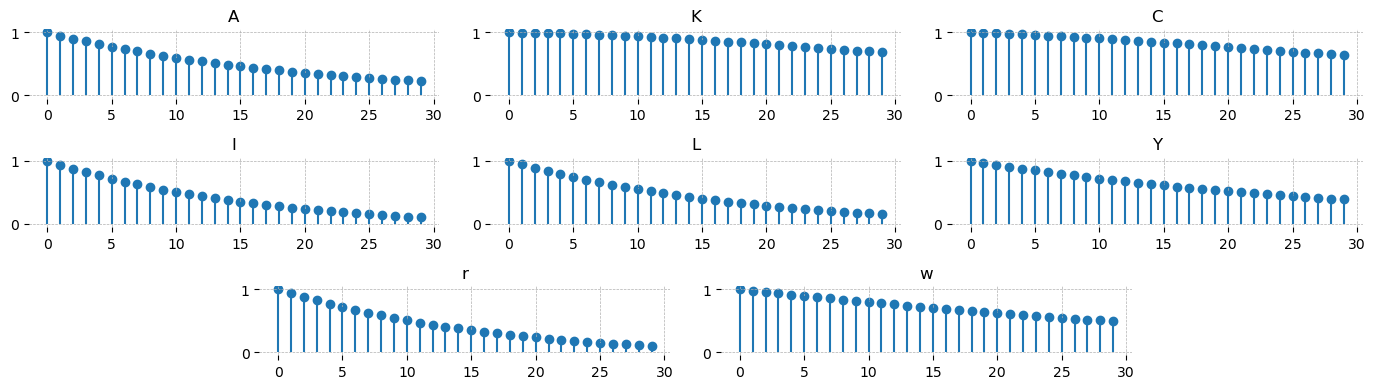

In [17]:
gp.plot_acf(acorr_matrix, vars_to_plot=['A', 'K', 'C', 'I', 'L', 'Y', 'r', 'w'], n_cols=3);

# Simulation

You can simulate the model by passing a covariance matrix for the shocks. The default is a spaghetti plot, but you can also ask for confidence intervals if you prefer a cleaner look.

In [18]:
simulation = model.simulate(shock_cov_matrix=np.eye(1) * 0.01, n_simulations=100)

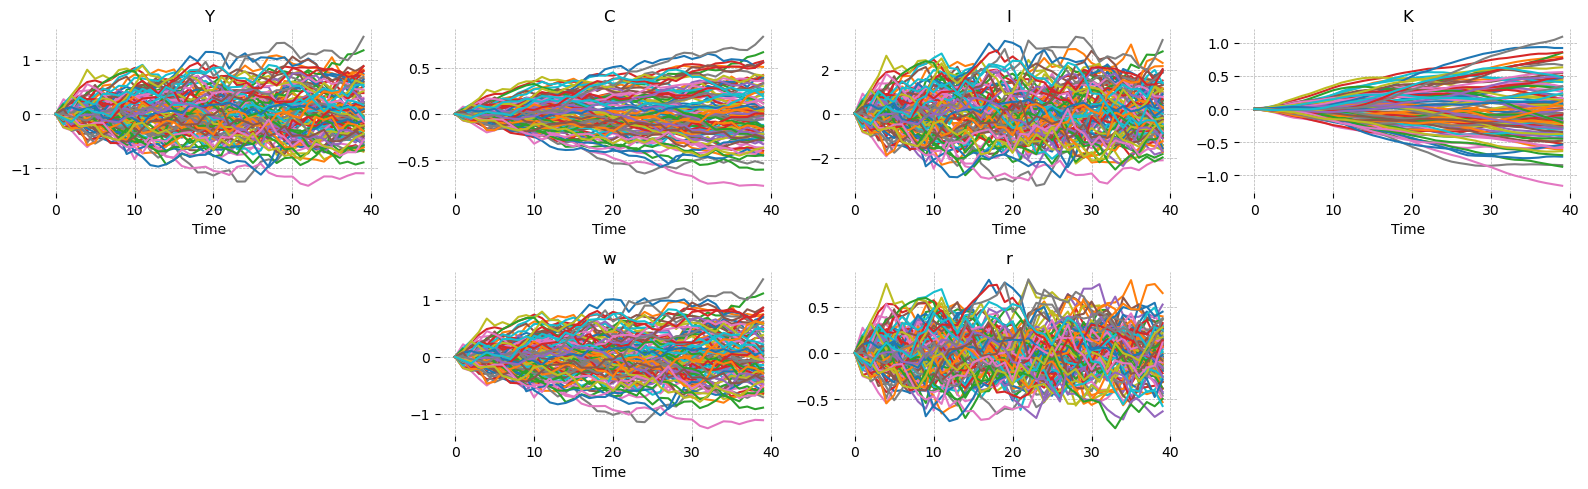

In [19]:
gp.plot_simulation(simulation, vars_to_plot=['Y', 'C', 'I', 'K', 'w', 'r'],
                   n_cols=4, figsize=(16, 5));

The confidence intervals need plenty of simulations or else they come out looking quite "jagged".

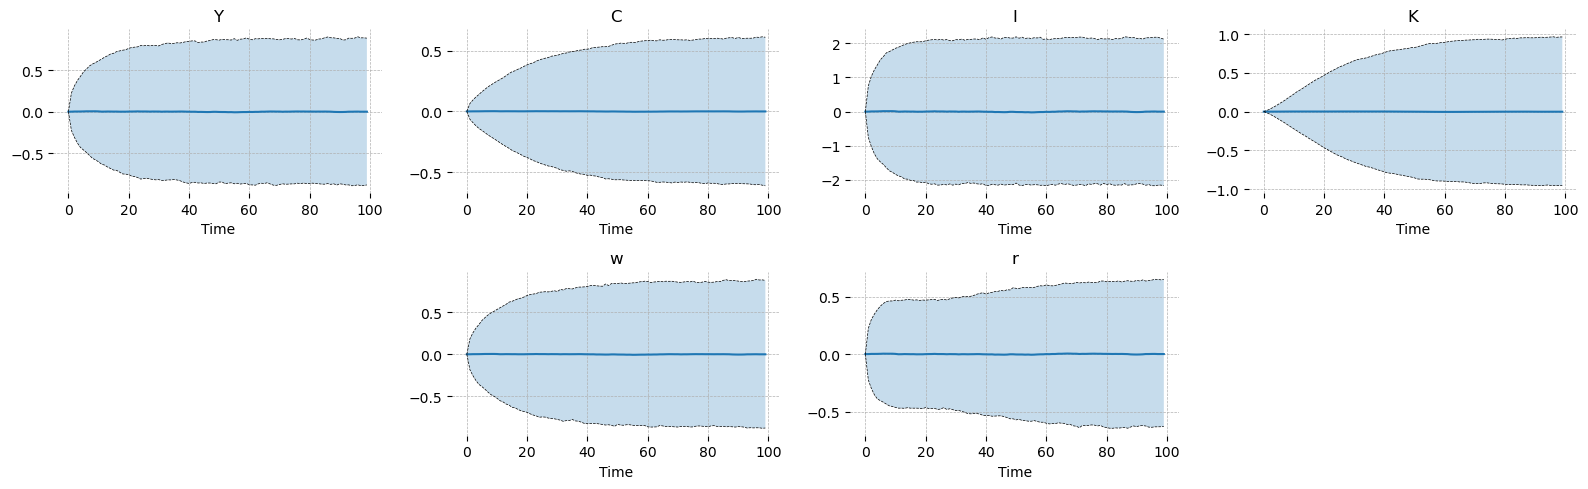

In [20]:
simulation = model.simulate(shock_cov_matrix=np.eye(1) * 0.01, n_simulations=10_000, simulation_length=100)
gp.plot_simulation(simulation, vars_to_plot=['Y', 'C', 'I', 'K', 'w', 'r'], ci=0.95,
                   n_cols=4, figsize=(16, 5));

With a large number of simulations you can also compute sample statistics and verify the stationary solution. Evidently they match to about the 2nd decimal place with 10_000 samples at T=99. One could extend `simulation_length` and increase `n_simulations` to obtain more accurate estimates.

In [21]:
import pandas as pd

tols = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
accuracy_df = pd.DataFrame(0, columns=tols, index=simulation.index)
for tol in tols:
    accuracy_df[tol] = ((simulation.xs(axis=1, key=99).T.cov() - sigma).abs() < tol).all()
print('Absolute difference between stationary covariance matrix and sample covariance matrix is less than:')
print(accuracy_df.to_string())

Absolute difference between stationary covariance matrix and sample covariance matrix is less than:
           0.10000  0.01000  0.00100  0.00010  0.00001
Variables                                             
A             True     True    False    False    False
C             True     True    False    False    False
I             True     True    False    False    False
K             True     True    False    False    False
L             True     True     True    False    False
TC            True     True    False    False    False
U             True     True     True    False    False
Y             True     True    False    False    False
lambda        True     True    False    False    False
mc            True     True     True     True     True
q             True     True    False    False    False
r             True     True    False    False    False
w             True     True    False    False    False


# Impulse Response Functions

In [22]:
irf = model.impulse_response_function(shock_size=0.01, simulation_length=40)

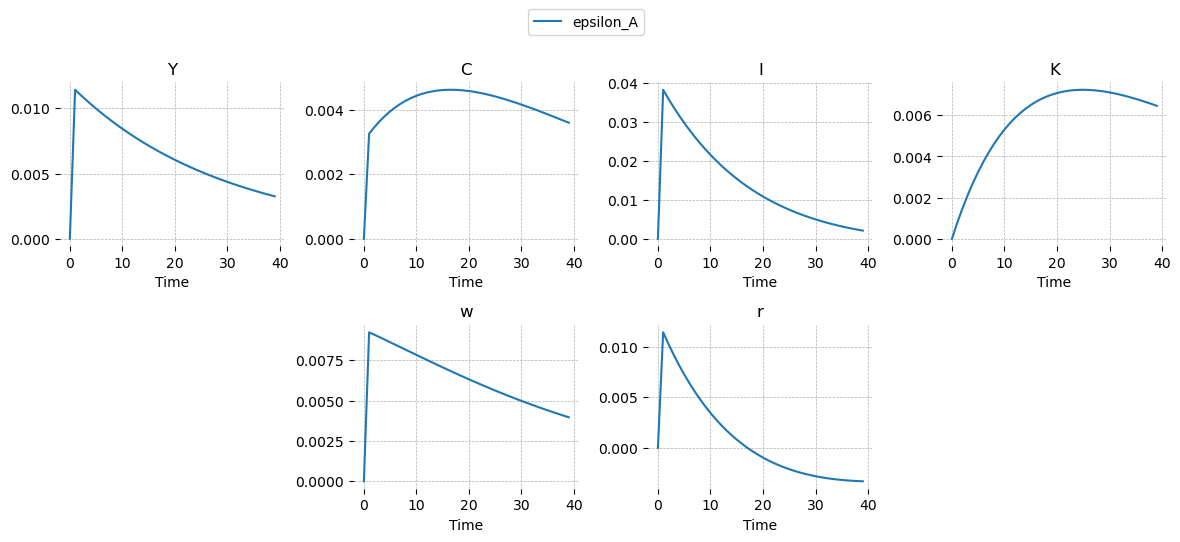

In [23]:
gp.plot_irf(irf, vars_to_plot=['Y', 'C', 'I', 'K', 'w', 'r'],
            n_cols=4, figsize=(12, 5), legend=True);

# Covnert to Dynare

Since Dynare remains the gold standard for DSGE model analysis, gEcon.py can convert the model into a Dynare `.mod` file. Greek variable names are automatically prefixed with either `var_` or `param_`, to avoid any namespace collisions in Matlab. 

In [24]:
print(make_mod_file(model))

var A, C, I, K, L, TC, U, Y, mc, q, r, var_lambda, w;
varexo epsilon_A;

parameters param_alpha, param_beta, param_delta, rho_A;
parameters sigma_C, sigma_L;

param_alpha = 0.35;
param_beta = 0.99;
param_delta = 0.02;
rho_A = 0.95;
sigma_C = 1.5;
sigma_L = 2.0;

model;
-C - I + K(-1) * r + L * w = 0;
I - K + K(-1) *(1 - param_delta) = 0;
C ^(1 - sigma_C) /(1 - sigma_C) - L ^(sigma_L + 1) /(sigma_L + 1) - U + U(1) * param_beta = 0;
-var_lambda + C ^(- sigma_C) = 0;
-L ^ sigma_L + var_lambda * w = 0;
q - var_lambda = 0;
param_beta *(q(1) *(1 - param_delta) + r(1) * var_lambda(1)) - q = 0;
1 - mc = 0;
A * K(-1) ^ param_alpha * L ^(1 - param_alpha) - Y = 0;
-K(-1) * r - L * w - TC = 0;
A * K(-1) ^(param_alpha - 1) * L ^(1 - param_alpha) * param_alpha * mc - r = 0;
A * K(-1) ^ param_alpha * mc *(1 - param_alpha) / L ^ param_alpha - w = 0;
epsilon_A + rho_A * log(A(-1)) - log(A) = 0;
end;

initval;
A = 1.0000;
C = 2.3584;
I = 0.7146;
K = 35.7323;
L = 0.8201;
TC = -3.0731;
U = -148.6156;
Y = 

# Adding a steady state block

RBC_steady_state.gcn shows how you can define a steady state in the GCN file to make the job of the numerical solver easier. 

* If you provide a complete steady-state solution, gEcon.py will check the residuals of your solution and report if there is an error, but will not resort to using a numerical solver.

* If you provide a partial steady-state solution, the relationships you provide will be substituted into the remaining equations, the system will be reduced via Sympy.simplify, and the remaining system of equations will be passed to the numerical solver.

In [25]:
file_path = 'GCN Files/RBC_steady_state.gcn'
model = gEconModel(file_path, verbose=True)

Model Building Complete.
Found:
	13 equations
	13 variables
	1 stochastic shock
		 0 / 1 has a defined prior. 
	6 parameters
		 0 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Steady-State Equations

Steady state equations are stored in the `model.steady_state_relationships` dictionary, with string keys of the form "Y_ss". I convert them to TimeAwareSymbols here to show the equations.

Admittedly, they aren't very easy to read in sympy. This could maybe be improved by adding additional assumptions to the variables (positive only, real only, etc), and using some clever arguments on `sp.simplify`. I'm not a Sympy expert.

Note that in this example, I have entered the entire steady state solution. In a more complex model, this may not be possible. In that case, you can pass only a subset of steady state relationships, and allow the combination of the heuristic solver and scipy optimizer to find everything else. 

Either way, for anything beyond a simple model, it is strongly recommended to pass as much steady state information as possible.

In [26]:
from gEcon.classes.time_aware_symbol import TimeAwareSymbol
for var, eq in model.steady_state_relationships.items():
    sp_var = TimeAwareSymbol(var.split('_')[0], time_index='ss')
    display(sp.Eq(sp_var, eq))

Eq(A_ss, 1.0)

Eq(C_ss, (((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha))**(sigma_L + 1)/(1 - alpha)**sigma_L)**(1/sigma_C)*(((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha)*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha)))**sigma_L)**(1/(sigma_C + sigma_L)))**((-sigma_L)/sigma_C))

Eq(I_ss, alpha*delta*((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha)*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha)))**sigma_L)**(1/(sigma_C + sigma_L))/(-(1 - delta) + 1/beta))

Eq(K_ss, alpha*((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha)*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha)))**sigma_L)**(1/(sigma_C + sigma_L))/(-(1 - delta) + 1/beta))

Eq(L_ss, ((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha)*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha)))**sigma_L)**(1/(sigma_C + sigma_L))/(alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha)))

Eq(P_ss, 1.0)

Eq(TC_ss, -alpha*((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha)*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha)))**sigma_L)**(1/(sigma_C + sigma_L)) - ((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha)*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha)))**sigma_L)**(1/(sigma_C + sigma_L))*(1 - alpha))

Eq(U_ss, (((((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha))**(sigma_L + 1)/(1 - alpha)**sigma_L)**(1/sigma_C)*(((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha)*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha)))**sigma_L)**(1/(sigma_C + sigma_L)))**((-sigma_L)/sigma_C))**(1 - sigma_C)/(1 - sigma_C) - (((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha)*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha)))**sigma_L)**(1/(sigma_C + sigma_L))/(alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha)))**(sigma_L + 1)/(sigma_L + 1))/(1 - beta))

Eq(Y_ss, ((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha)*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha)))**sigma_L)**(1/(sigma_C + sigma_L)))

Eq(lambda_ss, ((((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha))**(sigma_L + 1)/(1 - alpha)**sigma_L)**(1/sigma_C)*(((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha)*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha)))**sigma_L)**(1/(sigma_C + sigma_L)))**((-sigma_L)/sigma_C))**(-sigma_C))

Eq(q_ss, ((((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha))**(sigma_L + 1)/(1 - alpha)**sigma_L)**(1/sigma_C)*(((-(1 - delta) + 1/beta)/(-alpha*delta - (1 - delta) + 1/beta))**(sigma_C/(sigma_C + sigma_L))*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha)*((alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha)))**sigma_L)**(1/(sigma_C + sigma_L)))**((-sigma_L)/sigma_C))**(-sigma_C))

Eq(r_ss, -(1 - delta) + 1/beta)

Eq(w_ss, (alpha/(-(1 - delta) + 1/beta))**(alpha/(1 - alpha))*(1 - alpha))

## Solve Steady State

Since the entire steady state is provided, it solves much more quickly. Several expensive symbolic reduction loops are skipped.

In [27]:
%time model.steady_state()
model.print_steady_state()

Steady state found! Sum of squared residuals is 1.8273223312346094e-30
Wall time: 79.8 ms
A_ss               1.000
C_ss               2.358
I_ss               0.715
K_ss              35.732
L_ss               0.820
P_ss               1.000
TC_ss             -3.073
U_ss            -148.616
Y_ss               3.073
lambda_ss          0.276
q_ss               0.276
r_ss               0.030
w_ss               2.436


Nevertheless, you still get additonal speedup after the solution function is complied in the first execution.

In [28]:
%time model.steady_state()

Steady state found! Sum of squared residuals is 1.8273223312346094e-30
Wall time: 0 ns


## Perturbation Solution

Sadly, nothing special happens in the perturbation solver.

In [29]:
model.solve_model()

Gensys found a unique solution.
Policy matrices have been stored in attributes model.P, model.Q, model.R, and model.S
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [30]:
for name, policy_matrix in zip(['P', 'Q', 'R', 'S'], [model.P, model.Q, model.R, model.S]):
    print(name.center(10).center(50, '='))
    print(policy_matrix.to_string())

====================    P     ====================
        A_t-1     K_t-1
A_t  0.950000  0.000000
K_t  0.072814  0.969745
====================    Q     ====================
     epsilon_A_t
A_t     1.000000
K_t     0.076646
====================    R     ====================
             A_t-1     K_t-1
C_t       0.309657  0.478747
I_t       3.640697 -0.512728
L_t       0.206602 -0.156647
P_t       0.000000  0.000000
TC_t      1.084291  0.248179
U_t      -0.091155 -0.067054
Y_t       1.084291  0.248179
lambda_t -0.464485 -0.718121
q_t      -0.464485 -0.718121
r_t       1.084291 -0.751821
w_t       0.877689  0.404826
====================    S     ====================
          epsilon_A_t
C_t          0.325955
I_t          3.832313
L_t          0.217476
P_t          0.000000
TC_t         1.141359
U_t         -0.095953
Y_t          1.141359
lambda_t    -0.488932
q_t         -0.488932
r_t          1.141359
w_t          0.923883


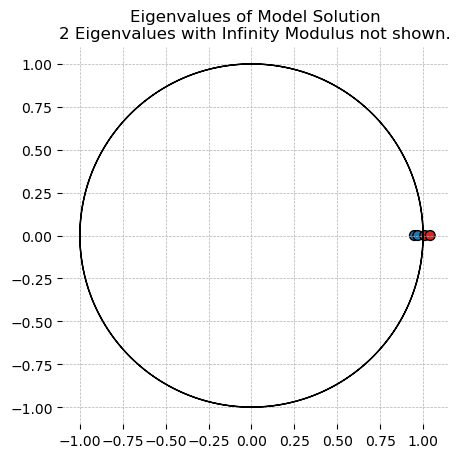

In [31]:
gp.plot_eigenvalues(model);

## Impulse Response Functions

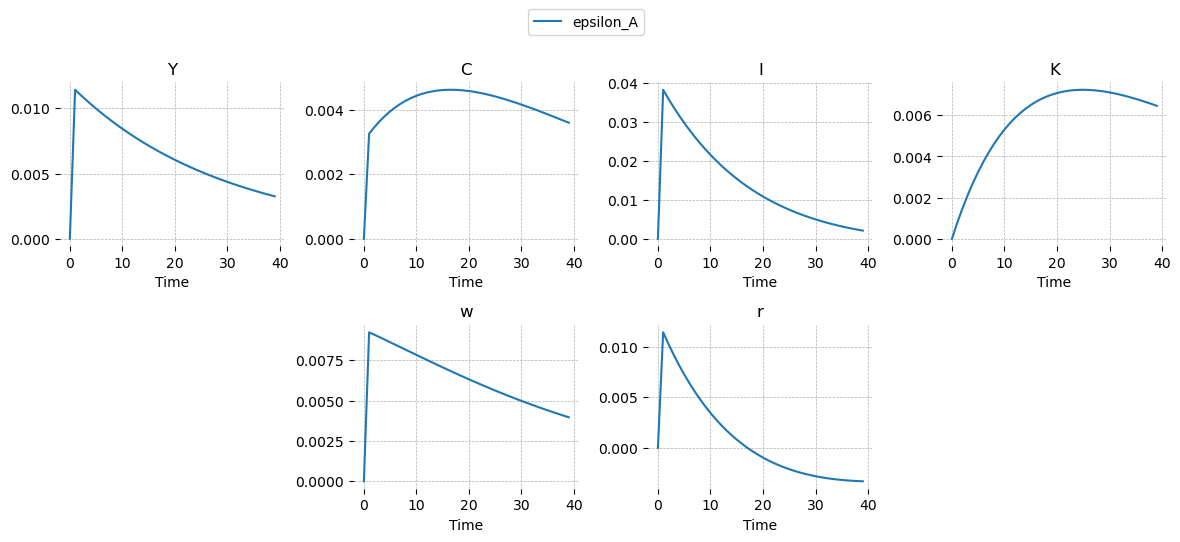

In [32]:
irf = model.impulse_response_function(shock_size=0.01, simulation_length=40)

gp.plot_irf(irf, vars_to_plot=['Y', 'C', 'I', 'K', 'w', 'r'],
            n_cols=4, figsize=(12, 5), legend=True);

## Conversion to Dynare

I haven't added support for automatic conversion of steady state equations into a Dynare steady state block, but this is coming soon.

# Priors

With gEcon.py, you can directly declare priors over parameters and shocks using a natural `~` notation. RBC_priors.gcn shows the following features:

1. Prior declaration

Priors are declared directly in the GCN file using the following notation:

```
sigma_C ~ N(mu=1.5, sd=0.1, lower=1.0) = 1.5;
sigma_L ~ N(loc=2.0, scale=0.1, lower=1.0) = 2.0;
```

These parameters are drawn from normal distributions, which can be parameterized using `loc` and `scale`, or `mu` and `sigma`. All supported distributions can be parameterized via their moments or via loc-scale-shape. See the scipy documentation of a distribution for details on the latter. Supported distributions are Normal, Beta, HalfNormal, Gamma, Inverse Gamma, Uniform, and Truncated Normal. These two distributions are actually truncated normals -- gEcon.py will automatically try to convert a normal distribution to a truncated distribution if bounds, lower or upper, are declared.

The `=` sign after the distribution declares the initial value of the distribution.


2. Compound distributions

Distributions in gEcon can be parameterized by other distributions. This is especially useful when declaring shock distributions:

```
shocks
{
    epsilon_A[] ~ N(mean=0, sd=sigma_epsilon);
};

calibration
{
    rho_A ~ Beta(mean=0.95, sd=0.04) = 0.95;
    sigma_epsilon ~ Inv_Gamma(mean=0.1, sd=0.01) = 0.01;
};
```

The technology innovation `epsilon_A` is a normal distribution with a random standard deviation that follows an inverse gamma distribution. When you ask for samples of `epsilon_A` from the model, it will automatically draw from the inverse_gamma, then draw from the normal conditional on the sampled value of `sigma_epsilon`.

Note also that `rho_A` is defined using the first and second moments of the beta distribution. One could also pass shape parameters `a` and `b`, or use `loc` and `scale` to further shift or scale the beta distribution.

Finally, note that because `epsilon_A` is a variable, not a parameter (it has `[]`), there is no initial value assigned after the distribution. An error will be raised if you try to give it one.

In [33]:
file_path = 'GCN Files/RBC_priors.gcn'
model = gEconModel(file_path, verbose=True)

Model Building Complete.
Found:
	13 equations
	13 variables
	1 stochastic shock
		 1 / 1 has a defined prior. 
	6 parameters
		 4 / 6 have a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



Initial values are whatever is given after the `=`, as explained above.

In [34]:
model.free_param_dict

{'alpha': 0.35,
 'beta': 0.99,
 'delta': 0.02,
 'rho_A': 0.95,
 'sigma_C': 1.5,
 'sigma_L': 2.0}

Priors are stored in two places. Parameters are in `model.param_priors`, while the shocks are in `model.shock_priors`

In [35]:
model.param_priors

{'sigma_C': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ae34c28d90>,
 'sigma_L': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ae34c28b20>,
 'alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ae34c28280>,
 'rho_A': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ae34c41d90>}

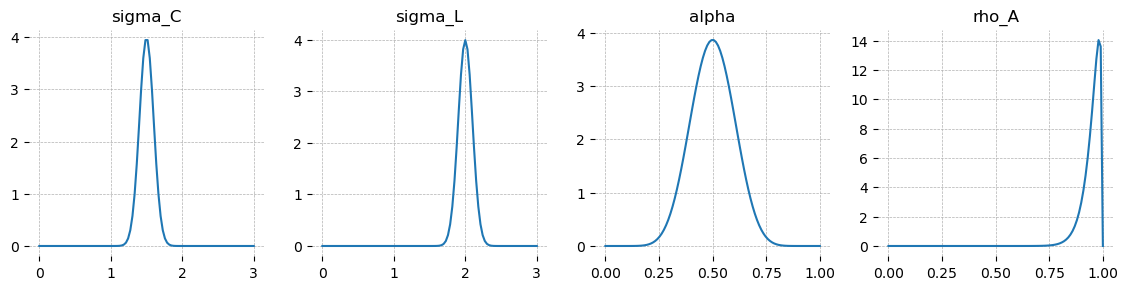

In [36]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4, figsize=(14,3), dpi=100)
for axis, (param, d) in zip(fig.axes, model.param_priors.items()):
    lower, upper = d.a, d.b
    lower = max(lower, 0)
    upper = min(3, upper)
    x_grid = np.linspace(lower, upper, 100)
    axis.plot(x_grid, d.pdf(x_grid))
    axis.set(title=param)
    [spine.set_visible(False) for spine in axis.spines.values()]
    axis.grid(ls='--', lw=0.5)
plt.show()

As described above, `epsilon_A` is a composite distribution that first draws from `sigma_epsilon`, then draws from `epsilon_A`

In [37]:
model.shock_priors

{'epsilon_A': <gEcon.parser.parse_distributions.CompositeDistribution at 0x1ae34c41a60>}

The underlying distributions can be accessed if needed using `rv_params`, for "random variable parameters".

In [38]:
model.shock_priors['epsilon_A'].rv_params

{'scale': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ae34c41e80>}

In [39]:
scale_grid = np.linspace(0.05, 0.15, 100)
eps_grid = np.linspace(-0.25, 0.25, 100)

xx, yy = np.meshgrid(scale_grid, eps_grid)

pdf_grid = [[model.shock_priors['epsilon_A'].pdf({'scale':scale, 'obs':eps}) 
             for scale in scale_grid] for eps in eps_grid]

Compared to a standard Normal distribution, we get fatter tails by parameterizing the standard deviation with an inverse gamma distribution.

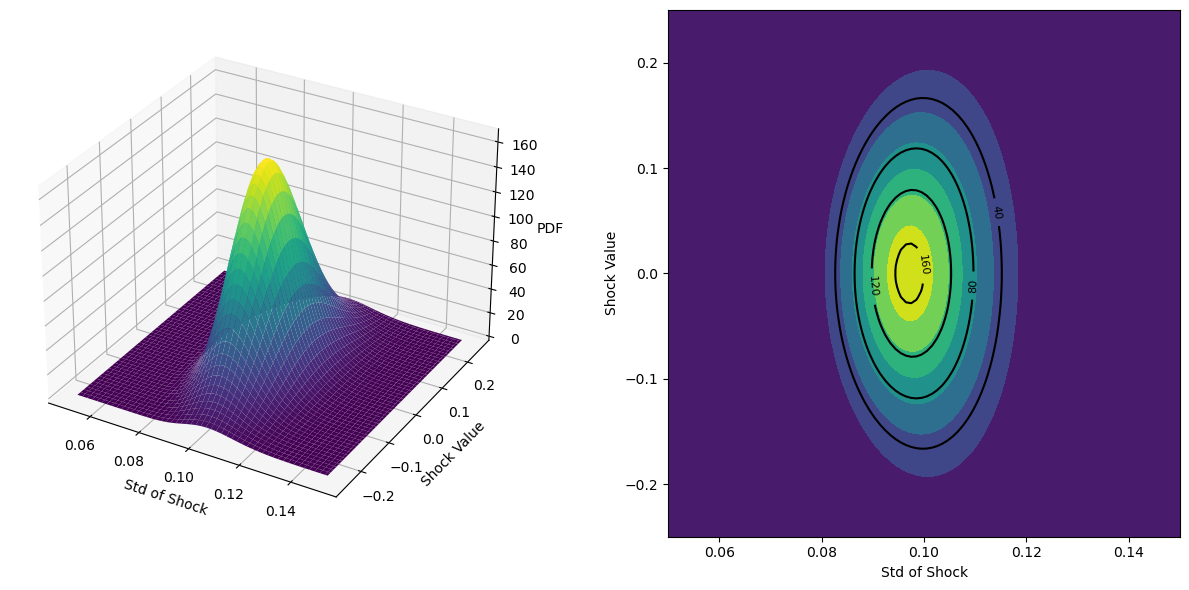

In [40]:
fig = plt.figure(figsize=(12,6), dpi=100)
gs = fig.add_gridspec(1, 2)

axis = fig.add_subplot(gs[:, 0], projection='3d')
axis.plot_surface(xx, yy, np.array(pdf_grid), cmap='viridis')
axis.set(xlabel='Std of Shock', ylabel='Shock Value', zlabel='PDF')
axis = fig.add_subplot(gs[:, 1])
cs = axis.contour(xx, yy, pdf_grid, levels=4, colors='k')
axis.contourf(xx, yy, pdf_grid)
axis.clabel(cs, cs.levels, inline=True, fontsize=8)
axis.set(xlabel='Std of Shock', ylabel='Shock Value')
fig.tight_layout(w_pad=6)

In [41]:
model.steady_state()
model.print_steady_state()

Steady state found! Sum of squared residuals is 1.5162530527818997e-20
A_ss               1.000
C_ss               2.358
I_ss               0.715
K_ss              35.732
L_ss               0.820
TC_ss             -3.073
U_ss            -148.616
Y_ss               3.073
lambda_ss          0.276
mc_ss              1.000
q_ss               0.276
r_ss               0.030
w_ss               2.436


In [42]:
model.solve_model()

Gensys found a unique solution.
Policy matrices have been stored in attributes model.P, model.Q, model.R, and model.S
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


## Model Statistics

Model statistics are computed at the initial values of the parameters -- there is no integration of the prior information into the stationary covariance matrix or autocorrelation function. 

## Simulation

Simulation becomes more conventient with defined priors, you don't need to pass a covariance matrix anymore. You still can -- doing so will draw innovations from the supplied covarainces rather than from the defined prior distributions.

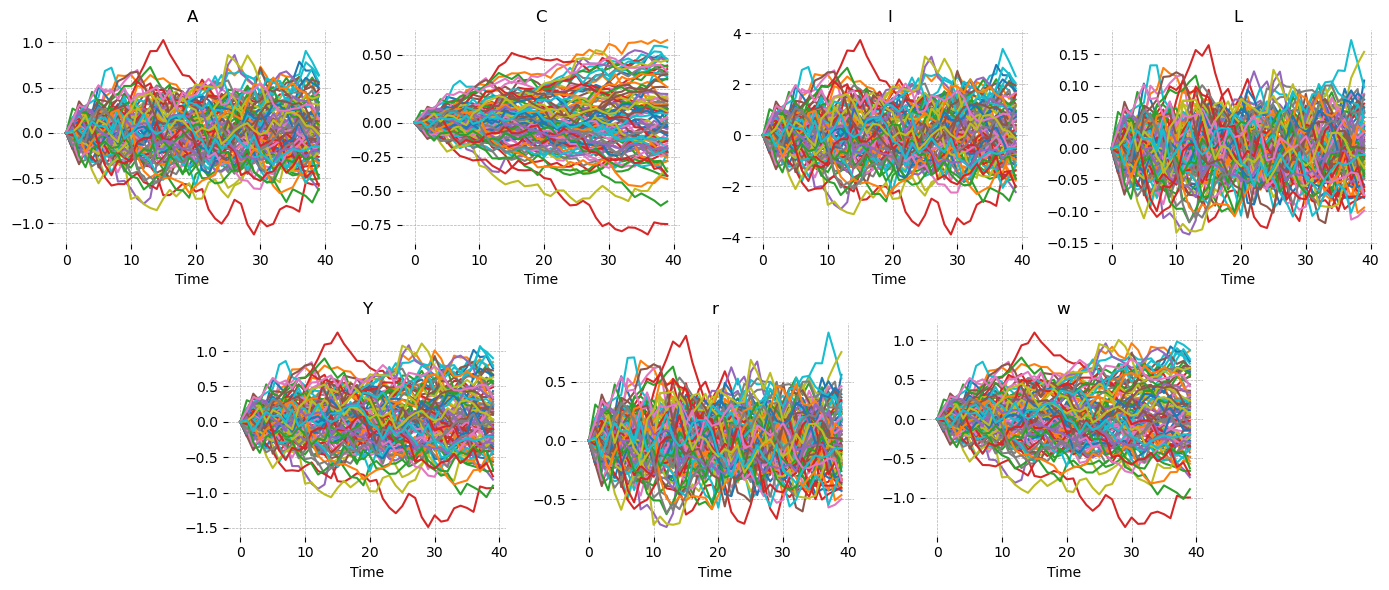

In [43]:
gp.plot_simulation(model.simulate(), figsize=(14,6), vars_to_plot=['A', 'C', 'I', 'L', 'Y', 'r', 'w']);

## Useful things to do with priors

Researchers usually assign priors because they want to run a bayesian estimation of the model. This functionality is coming of course, but in the mean time there are other useful things one can do.

### Simulation from Prior

An excellent first step is to simulate model trajectories from draws of the prior, to see if they are reasonable. If your priors generate crazy outputs, they should probably be adjusted prior to estimation. The function `simulate_trajectories_from_prior` helps with this. It has 3 important parameters: `n_samples` is the number of draws from the prior, `n_simulations` is the number of trajectories to draw from each parameter combination sampled from the prior, and `simulation_length` controls the... length of the simulation.

This will return up to `n_samples x n_simulations x simulation_length` values, which can be a lot, so be aware it might take some time, especially if the prior produces samples in bad regions of the parameter space (see below).

In [44]:
from gEcon.sampling.prior_utilities import simulate_trajectories_from_prior

simulations = simulate_trajectories_from_prior(model, n_samples=1000, n_simulations=100, simulation_length=40)

Sampling 1000 / 1000 [==================================================] elapsed: 00:58, remaining: 00:00, 17.18iter/secc


The spaghetti plots can take a long time to draw for these, passing a CI will speed things up considerably.

In [ ]:
gp.plot_simulation(simulations, vars_to_plot=['A', 'Y', 'C', 'I', 'K'], figsize=(14,6), ci=0.95);

### Steady State Bounds

It is also possible that your priors will generate samples that are in regions of parameter space which have no associated steady state. You can check how the steady state handles different values from the priors using the `plot_prior_steady_state_solvability` function in the plotting tools.

Here it seems that the prior over `alpha` is much too wide -- after 0.5 the model isn't able to solve a steady state anymore. This would cause a lot of headaches for an MCMC sampler because of an apparent discontinunity in the parameter space. It could potentially be solved by providing steady state equations. Whether this discontinunity is a mathmatical feature of the model or whether it is an artefact from the numerical solver would need to be investigated.

In [ ]:
gp.plot_prior_steady_state_solvability(model, n_samples=1000, seed=1337);

You can change a prior by changing the GCN, or by directly assigning a new scipy distribution in the `model.param_priors` dictionary. Assigning a new prior is nice for testing, but it won't save to the GCN and will revert back the next time you load the model.

In [ ]:
from scipy import stats

In [ ]:
# The mean of a beta distribution is a / (a + b), and the variance is ab / ((a + b)^2 + (a + b + 1))
# Use sympy to solve for parameters a, b given desired moments.
from sympy.abc import a, b

eq1 = 0.35 - a / (a + b)
eq2 = 0.1 - sp.sqrt(a*b / (a + b) ** 2 / (a + b + 1))
a, b = sp.solve([eq1, eq2], a,b)[0]
print(a, b)
d = stats.beta(a=float(a), b=float(b))
d.stats()

In [ ]:
model.param_priors['alpha'] = d

After the change the model is much more sample efficient. It might be nice to hard-code a boundary at 0.5, but this is not currently supported with a beta distribution, because I haven't added improper priors. Currently, options would be to use a truncated normal or further shrink the variance.

Note that sampling the prior and repeatedly solving the steady state sped up considerably by shifting the piror to a better region of the parameter space.

In [ ]:
gp.plot_prior_steady_state_solvability(model, n_samples=1000, seed=1337);